# Propeller identification
We want to charchterize the transfer function of a drone propeller (BLDC motor) by measuring a set of datapoints and applying machine learning techniques to approximate the parameters

In [2]:
import pandas
import serial   # pip install pyserial, not pip install serial !

## Collection of the data points
We collect data by interfacing the computer and the board via a serial port.
In the PC side we use the pySerial library

In [3]:
# Serial port parameters
port = '/dev/ttyUSB1'   # Depends on the OS
baud = 9600
timeout = 3

# Open te serial port
ser = serial.Serial(port, baud, timeout=timeout)
ser.flush()

We now define two function to simplify reading and writing data via the serial port.
Note that this is specific to this particular setup.

In [4]:
# Returns a string, already decoded and polished
def my_readline():
    line = ser.readline().decode('UTF-8').strip()
    return line

# Writes a message, following the protocol we defined:
# <message>
def my_write(message):
    ser.write(("<"+message+">").encode())

In [6]:
import csv

# Given the parameters, build the message string
def build_message(command, n_samples, step, max_pwm):
    # The words are separated by a space
    message = " ".join([command, str(n_samples), str(step), str(max_pwm)])
    return message

def build_message(list_of_string):
    message = " ".join(list_of_string)
    return message

# Given a message and a filename, send the message and store the data in the specified file
def get_dataset(message, filename):
    ser.flush()
    # Open the file
    file = open(filename, 'a')
    file.truncate(0)

    # Setup the csv
    csv_writer = csv.writer(file)

    # Send the command to get the measurements
    my_write(message)

    # Listen to the response
    while 1:
        # Read a line = a row of the matrix S = a sample
        line = my_readline()

        # Check if the line is empty => skip
        if line == '':
            continue

        # If there is something, I check if it is the termination message
        if line == "Finished":
            file.close()
            print("Finished")
            break

        # Forced stop
        if line == 'STOP':
            file.close()
            print("Stopped")
            break

        # Exception unhandled
        if line == 'Arduino is ready':
            print("Exception occured")
            break

        # If I'm here it is a proper sample
        print(line)
        values = line.split(',')
        if 'Message' in values[0]:
            continue
        
        csv_writer.writerow(values)

Finally we can collect the data

### Operating point

In [7]:
command = "O"
filename = "Operating_point.csv"

In [10]:
ser = serial.Serial(port, baud, timeout=timeout)
get_dataset(build_message([command]), filename)

Message received: O. Response:
0.241
Finished


In [13]:
data_frame_op = pandas.read_csv(filename)
print(data_frame_op[0])

KeyError: 0

### Ramp response
To get the data, we first must send a message to the board to tell how to measure. We have to send:
- command R to tell the board to test a ramp
- how many samples to average for each input value
- the distance between input values
- minimum and maximum values to be tested

After that, the board will start the test and will send back data, line by line.
Each line sent by the board is a sample, already formatted to be written in a .csv file.
While we read the data, we also write it into a .csv file to store all the samples.

In [11]:
# Collect the data for the ramp
command = 'R'   # Measure
n_samples = 10  # How many samples do I want to average for each input value
step = 5      # Step for the input signal
min_pwm = 1180   # Start from here
max_pwm = 1400 # Max value to test
filename = "Dataset_ramp copy.csv"

In [ ]:
ser = serial.Serial(port, baud, timeout=timeout)
get_dataset(build_message([command, str(n_samples), str(step), str(min_pwm), str(max_pwm)]), filename)

#### Plot
Check that the data we got is good

In [12]:
data_frame_ramp = pandas.read_csv(filename)
print(data_frame_ramp.tail())

        PWM       RPM  Thrust
120  1780.0  9263.889   0.736
121  1785.0  9288.803   0.731
122  1790.0  9296.439   0.727
123  1795.0  9259.141   0.728
124  1800.0  9256.903   0.727


<Axes: xlabel='RPM', ylabel='Thrust'>

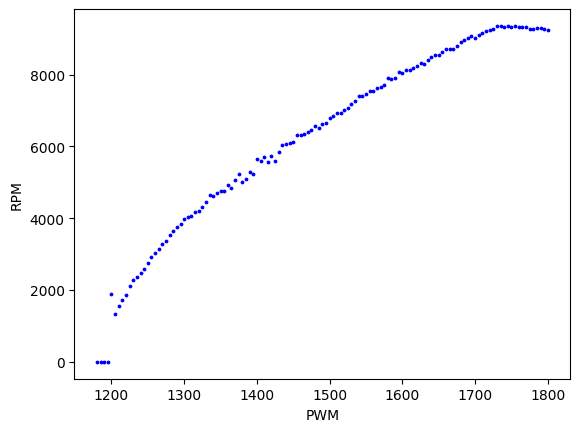

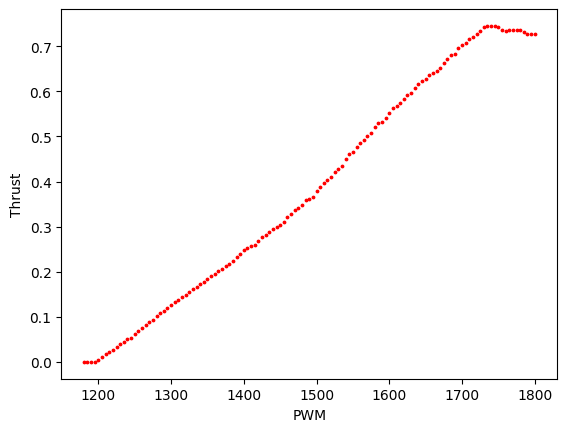

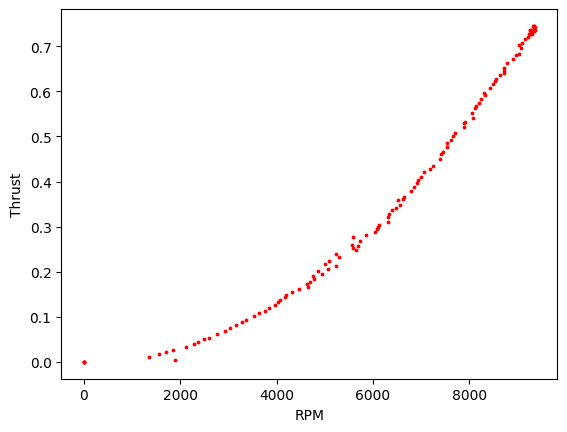

In [13]:
# https://matplotlib.org/stable/tutorials/introductory/quick_start.html#sphx-glr-tutorials-introductory-quick-start-py
import matplotlib.pyplot as plt

data_frame_ramp.plot(x='PWM', y='RPM', kind='scatter', s=3, c='blue')
data_frame_ramp.plot(x='PWM', y='Thrust', kind='scatter', s=3, c='red')
data_frame_ramp.plot(x='RPM', y='Thrust', kind='scatter', s=3, c='red')

## Step response
Now we measure the step response of the propeller.

The value at which we measure it coincides with the chosen operating point in the final system.

The command is built as follows:
- command S to tell the board to test a step
- operating point: the equilibrium point we operate at. It will be set as baseline for 2 seconds
- step value: offset from the operating point to test (ie the step amplitude)
- max_time: for how much time we test the step before stopping the motor

In this test, the board will send the data all together at the end, due to high frequency interrupts needed to study the fast dynamics of the motor

In [2]:
command = 'S'
operating_point = 1500
step_value = 200
max_time = 2000    # milliseconds
filename = 'Dataset_step.csv'

In [128]:
ser = serial.Serial(port, baud, timeout=timeout)
get_dataset(build_message([command, str(operating_point), str(step_value), str(max_time)]), filename)

Message received: S 1500 2000. Response: Command: S, Step: 0, max_time: 0
T,RPM
0,0
227, 263.736
262, 1709.889
290, 2158.584
314, 2533.677
337, 2545.717
360, 2673.439
382, 2652.168
404, 2770.467
426, 2738.476
447, 2851.304
468, 2809.515
489, 2915.735
510, 2869.578
530, 2973.241
550, 2919.992
570, 3020.996
590, 2963.988
610, 3062.474
630, 3000.600
649, 3096.934
669, 3032.907
688, 3128.259
708, 3061.537
727, 3155.570
746, 3086.102
765, 3179.145
785, 3107.520
803, 3198.976
823, 3125.000
841, 3215.951
860, 3142.842
879, 3233.804
898, 3156.898
916, 3245.699
935, 3167.062
954, 3255.915
973, 3177.461
991, 3264.063
1010, 3186.066
1028, 3275.109
1047, 3197.272
1065, 3284.432
1084, 3200.854
1102, 3287.671
1121, 3221.996
1139, 3317.300
1157, 3235.024
1176, 3319.869
1194, 3237.818
1212, 3323.916
1231, 3238.866
1249, 3323.363
1267, 3237.992
1285, 3322.259
1304, 3239.566
1322, 3323.363
1340, 3240.091
1358, 3325.205
1377, 3242.367
1395, 3327.418
1413, 3242.192
1432, 3326.496
1450, 3244.120
1468, 3330

        T        RPM
462  3975  11871.785
463  3980  11670.881
464  3985  11867.089
465  3990  11675.423
466  3995  11869.437


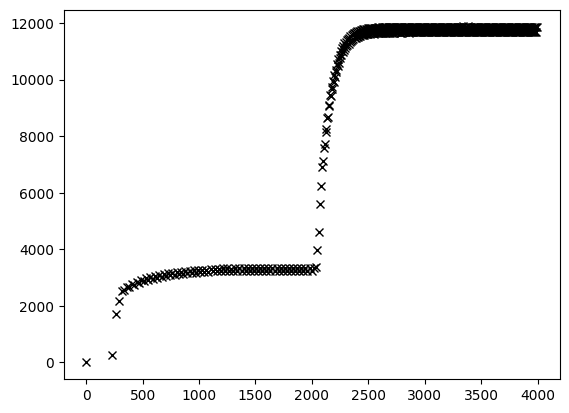

In [6]:
data_frame_step = pandas.read_csv(filename)
print(data_frame_step.tail())
fig,ax = plt.subplots()
ax.plot(data_frame_step['T'], data_frame_step['RPM'], 'kx')